In [ ]:
!pip install roboflow

## Download Dataset (Version 1)

In [ ]:
from roboflow import Roboflow
from google.colab import userdata

# Retrieve API key from Colab secrets
ROBO_API_KEY = userdata.get('ROBO_API_KEY')

rf = Roboflow(api_key=ROBO_API_KEY)
project = rf.workspace("nunnapas").project("fruit-rzujm")
dataset = project.version(1).download("folder")

loading Roboflow workspace...
loading Roboflow project...


## Verify Folder Structure

In [ ]:
import os

dataset_path = "./Fruit-1"

print("Train classes:", os.listdir(os.path.join(dataset_path, "train")))
print("Validation classes:", os.listdir(os.path.join(dataset_path, "valid")))
print("Test classes:", os.listdir(os.path.join(dataset_path, "test")))

Train classes: ['orange', 'watermelon', 'pineapple', 'apple', 'kiwi', 'cherry', 'banana', 'strawberries', 'mango', 'avocado']
Validation classes: ['orange', 'watermelon', 'pineapple', 'apple', 'kiwi', 'cherry', 'banana', 'strawberries', 'mango', 'avocado']
Test classes: ['orange', 'watermelon', 'pineapple', 'apple', 'kiwi', 'cherry', 'banana', 'strawberries', 'mango', 'avocado']


## Class Distribution

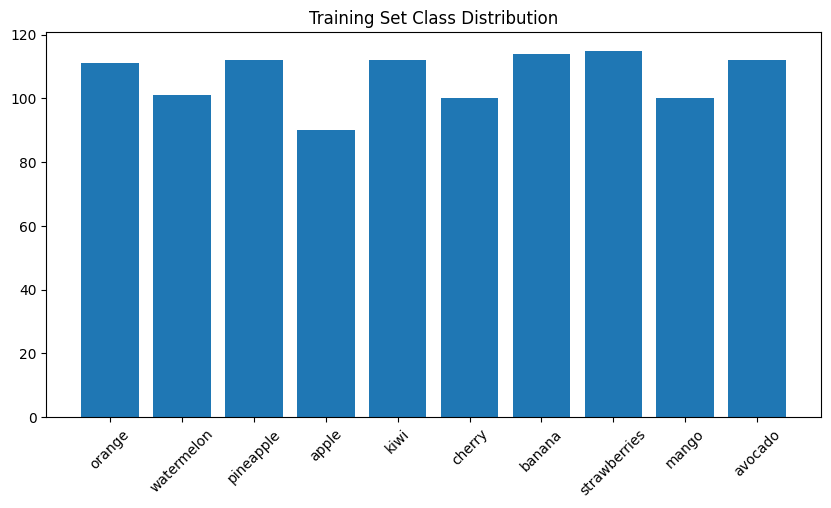

{'orange': 111, 'watermelon': 101, 'pineapple': 112, 'apple': 90, 'kiwi': 112, 'cherry': 100, 'banana': 114, 'strawberries': 115, 'mango': 100, 'avocado': 112}


In [ ]:
import matplotlib.pyplot as plt

train_dir = os.path.join(dataset_path, "train")

class_counts = {}
for class_name in os.listdir(train_dir):
    class_path = os.path.join(train_dir, class_name)
    class_counts[class_name] = len(os.listdir(class_path))

plt.figure(figsize=(10,5))
plt.bar(class_counts.keys(), class_counts.values())
plt.xticks(rotation=45)
plt.title("Training Set Class Distribution")
plt.show()

print(class_counts)

## Visual Inspection (Sanity Check)

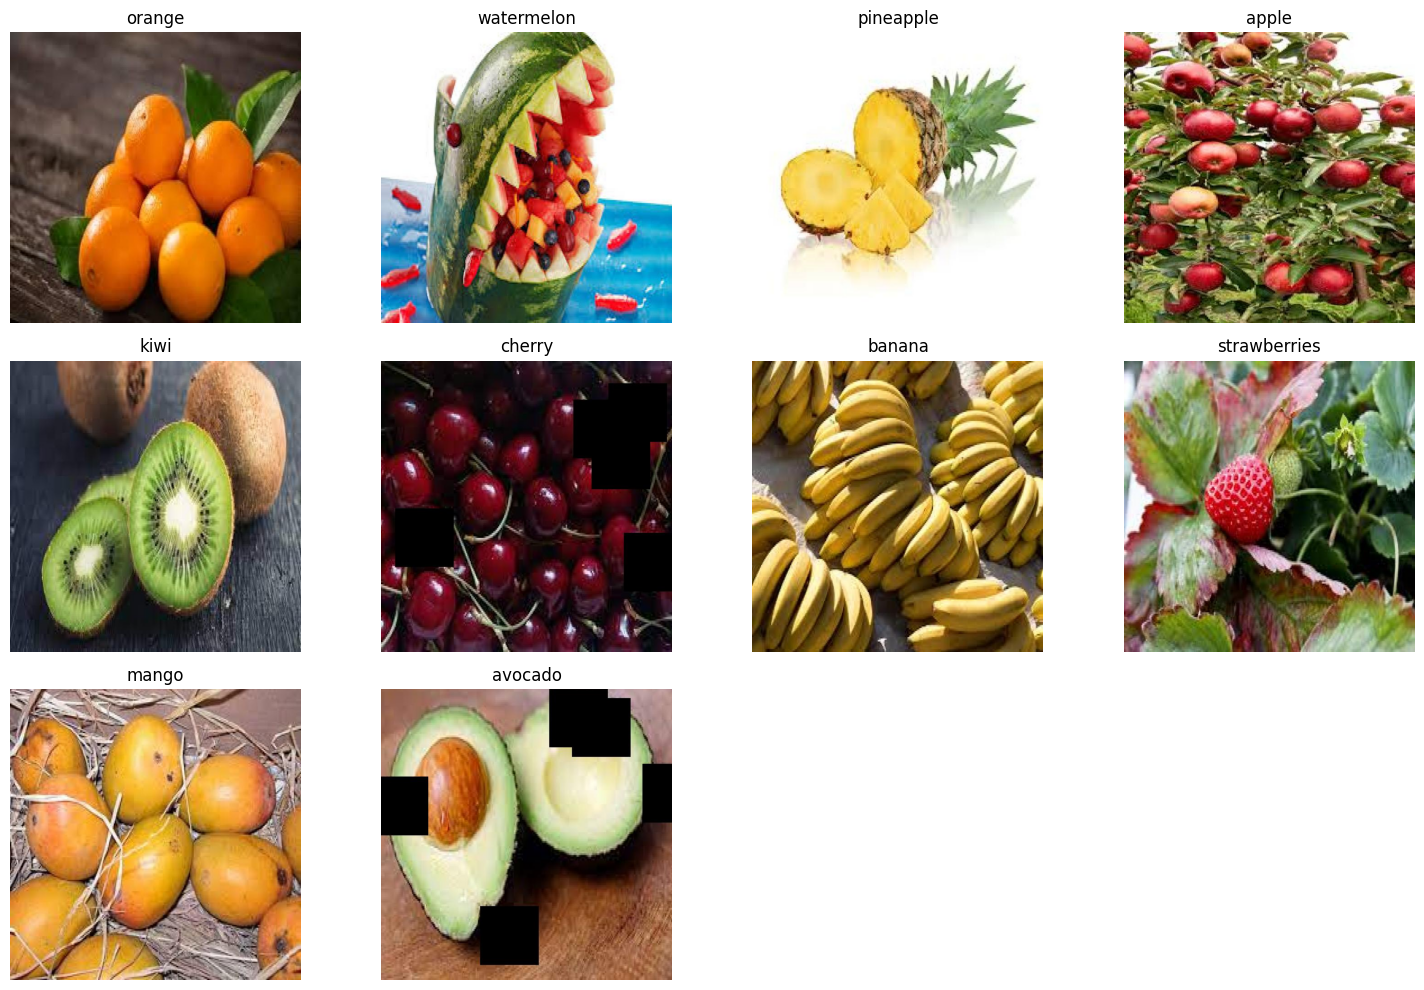

In [ ]:
import cv2
import numpy as np

plt.figure(figsize=(15,10))

# Filter out .ipynb_checkpoints and other non-data directories
class_names_to_process = [d for d in os.listdir(train_dir) if os.path.isdir(os.path.join(train_dir, d)) and d != '.ipynb_checkpoints']

for i, class_name in enumerate(class_names_to_process):
    class_path = os.path.join(train_dir, class_name)
    # Ensure the directory is not empty before trying to list its contents
    if len(os.listdir(class_path)) > 0:
        img_name = os.listdir(class_path)[0]
        img_path = os.path.join(class_path, img_name)

        img = cv2.imread(img_path)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

        plt.subplot(3,4,i+1)
        plt.imshow(img)
        plt.title(class_name)
        plt.axis("off")
    else:
        print(f"Warning: Class directory '{class_name}' is empty. Skipping.")

plt.tight_layout()
plt.show()

# Phase 1: Preprocessing & Data Pipeline

## Imports

In [ ]:
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications.mobilenet_v2 import preprocess_input
import os

## Define Paths

In [ ]:
train_dir = os.path.join(dataset_path, "train")
valid_dir = os.path.join(dataset_path, "valid")
test_dir  = os.path.join(dataset_path, "test")

## Data Generators

### Training Generators with Augmentation

In [ ]:
train_datagen = ImageDataGenerator(
    preprocessing_function=preprocess_input,
    rotation_range=20,
    zoom_range=0.2,
    width_shift_range=0.1,
    height_shift_range=0.1,
    horizontal_flip=True
)

In [ ]:
valid_datagen = ImageDataGenerator(
    preprocessing_function=preprocess_input
)

test_datagen = ImageDataGenerator(
    preprocessing_function=preprocess_input
)

## Flow from Directory

In [ ]:
IMG_SIZE = (224, 224)
BATCH_SIZE = 32

train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical'
)

valid_generator = valid_datagen.flow_from_directory(
    valid_dir,
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical'
)

test_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    shuffle=False
)

# Confirm the number of classes after re-initialization
print(f"Number of classes in train_generator: {train_generator.num_classes}")
print(f"Number of classes in valid_generator: {valid_generator.num_classes}")
print(f"Number of classes in test_generator: {test_generator.num_classes}")

Found 1067 images belonging to 10 classes.
Found 205 images belonging to 10 classes.
Found 102 images belonging to 10 classes.
Number of classes in train_generator: 10
Number of classes in valid_generator: 10
Number of classes in test_generator: 10


### Verify Class Mapping

In [ ]:
print(train_generator.class_indices)

{'apple': 0, 'avocado': 1, 'banana': 2, 'cherry': 3, 'kiwi': 4, 'mango': 5, 'orange': 6, 'pineapple': 7, 'strawberries': 8, 'watermelon': 9}


In [ ]:
import shutil

# Define paths for checkpoints in train, valid, and test directories
checkpoint_paths = [
    os.path.join(train_dir, ".ipynb_checkpoints"),
    os.path.join(valid_dir, ".ipynb_checkpoints"),
    os.path.join(test_dir, ".ipynb_checkpoints")
]

# Remove checkpoint directories if they exist
for path in checkpoint_paths:
    if os.path.exists(path):
        shutil.rmtree(path)
        print(f"Removed .ipynb_checkpoints from {os.path.basename(os.path.dirname(path))} folder")

In [ ]:
print(train_generator.class_indices)

{'apple': 0, 'avocado': 1, 'banana': 2, 'cherry': 3, 'kiwi': 4, 'mango': 5, 'orange': 6, 'pineapple': 7, 'strawberries': 8, 'watermelon': 9}


In [ ]:
images, labels = next(train_generator)
print(images.shape)
print(labels.shape)

(32, 224, 224, 3)
(32, 10)


# Phase 2: Model Development - Transfer Learning

## Load Pretrained Base Model

In [ ]:
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras import layers, models

base_model = MobileNetV2(
    weights='imagenet',
    include_top=False,
    input_shape=(224, 224, 3)
)

Why include_top=False?

Because we remove the original 1000-class ImageNet classifier.

We only want convolutional feature extractor.

## Freeze Base Model

In [ ]:
base_model.trainable = False

## Build Custom Classification Head

In [ ]:
model = models.Sequential([
    base_model,
    layers.GlobalAveragePooling2D(),
    layers.Dense(256, activation='relu'),
    layers.Dropout(0.5),
    layers.Dense(train_generator.num_classes, activation='softmax') # Dynamically set based on generator
])

## Compile Model

In [ ]:
model.compile(
    optimizer='adam',
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

## Early Stopping

In [ ]:
from tensorflow.keras.callbacks import EarlyStopping

early_stop = EarlyStopping(
    monitor='val_loss',
    patience=3,
    restore_best_weights=True
)

Why?

- Stops training when validation stops improving
- Prevents overfitting
- Saves best model automatically

## Train Model

In [ ]:
history = model.fit(
    train_generator,
    validation_data=valid_generator,
    epochs=15,
    callbacks=[early_stop]
)

Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.


Epoch 1/15
34/34 ━━━━━━━━━━━━━━━━━━━━ 83s 2s/step - accuracy: 0.3459 - loss: 2.1370 - val_accuracy: 0.8244 - val_loss: 0.5522
Epoch 2/15
34/34 ━━━━━━━━━━━━━━━━━━━━ 67s 2s/step - accuracy: 0.7941 - loss: 0.6022 - val_accuracy: 0.8293 - val_loss: 0.3997
Epoch 3/15
34/34 ━━━━━━━━━━━━━━━━━━━━ 67s 2s/step - accuracy: 0.8801 - loss: 0.3780 - val_accuracy: 0.8634 - val_loss: 0.3886
Epoch 4/15
34/34 ━━━━━━━━━━━━━━━━━━━━ 67s 2s/step - accuracy: 0.8934 - loss: 0.3278 - val_accuracy: 0.8537 - val_loss: 0.3923
Epoch 5/15
34/34 ━━━━━━━━━━━━━━━━━━━━ 66s 2s/step - accuracy: 0.9048 - loss: 0.2864 - val_accuracy: 0.8732 - val_loss: 0.3449
Epoch 6/15
34/34 ━━━━━━━━━━━━━━━━━━━━ 66s 2s/step - accuracy: 0.9259 - loss: 0.2275 - val_accuracy: 0.8732 - val_loss: 0.3731
Epoch 7/15
34/34 ━━━━━━━━━━━━━━━━━━━━ 66s 2s/step - accuracy: 0.9428 - loss: 0.1770 - val_accuracy: 0.8585 - val_loss: 0.4177
Epoch 8/15
34/34 ━━━━━━━━━━━━━━━━━━━━ 69s 2s/step - accuracy: 0.9305 - loss: 0.2022 - val_accuracy: 0.8585 - val_loss:

We allow up to 15 epochs.
Early stopping will likely stop earlier.

In [ ]:
model.summary()

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ mobilenetv2_1.00_224            │ (None, 7, 7, 1280)     │     2,257,984 │
│ (Functional)                    │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_2      │ (None, 1280)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 256)            │       327,936 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 10)             │         2,570 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 3,249,504 (12.40 MB)

 Trainable params: 330,506 (1.26 MB)

 Non-trainable params: 2,257,984 (8.61 MB)

 Optimizer params: 661,014 (2.52 MB)

# Phase 3: Fine-Tuning

Unfreeze Last 20–30 Layers

In [ ]:
base_model.trainable = True

# Freeze first 100 layers, unfreeze rest
for layer in base_model.layers[:100]:
    layer.trainable = False

MobileNetV2 has 155 layers approx.
We fine-tune only top ~55 layers.

Why not all?

Because:
Early layers detect edges We don’t want to destroy low-level feature

## Recompile with Low LR

In [ ]:
from tensorflow.keras.optimizers import Adam

model.compile(
    optimizer=Adam(learning_rate=1e-5),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

## Train Few Epochs

In [ ]:
history_fine = model.fit(
    train_generator,
    validation_data=valid_generator,
    epochs=10,
    callbacks=[early_stop]
)

Epoch 1/10
34/34 ━━━━━━━━━━━━━━━━━━━━ 101s 3s/step - accuracy: 0.8253 - loss: 0.5878 - val_accuracy: 0.8683 - val_loss: 0.3483
Epoch 2/10
34/34 ━━━━━━━━━━━━━━━━━━━━ 111s 3s/step - accuracy: 0.8629 - loss: 0.4368 - val_accuracy: 0.8683 - val_loss: 0.3577
Epoch 3/10
34/34 ━━━━━━━━━━━━━━━━━━━━ 105s 3s/step - accuracy: 0.8520 - loss: 0.4553 - val_accuracy: 0.8683 - val_loss: 0.3627
Epoch 4/10
34/34 ━━━━━━━━━━━━━━━━━━━━ 102s 3s/step - accuracy: 0.8677 - loss: 0.3992 - val_accuracy: 0.8683 - val_loss: 0.3703


# Phase 4: Evaluation & Analysis

In [ ]:
test_loss, test_accuracy = model.evaluate(test_generator)
print("Test Accuracy:", test_accuracy)

4/4 ━━━━━━━━━━━━━━━━━━━━ 4s 876ms/step - accuracy: 0.8824 - loss: 0.3848
Test Accuracy: 0.8725489974021912


## Detailed Evaluation & Analysis

### Classification Report

In [ ]:
from sklearn.metrics import classification_report
import numpy as np

# Get predictions
predictions = model.predict(test_generator)
y_pred = np.argmax(predictions, axis=1)
y_true = test_generator.classes

# Get class indices from the generator
class_indices = test_generator.class_indices
# Create a reverse mapping for class names
idx_to_class = {v: k for k, v in class_indices.items()}

# Get unique classes present in y_true, excluding the '.ipynb_checkpoints' class
unique_y_true_labels = np.unique(y_true)
actual_labels_in_y_true = sorted([label for label in unique_y_true_labels if idx_to_class[label] != '.ipynb_checkpoints'])

# Construct target_names using only the actual labels present and excluding the checkpoint
target_names_for_report = [idx_to_class[label] for label in actual_labels_in_y_true]

print(classification_report(y_true, y_pred, labels=actual_labels_in_y_true, target_names=target_names_for_report))

4/4 ━━━━━━━━━━━━━━━━━━━━ 8s 2s/step
              precision    recall  f1-score   support

       apple       0.69      0.82      0.75        11
     avocado       1.00      1.00      1.00        12
      banana       1.00      0.92      0.96        12
      cherry       0.57      0.67      0.62         6
        kiwi       0.78      0.88      0.82         8
       mango       0.82      1.00      0.90         9
      orange       0.90      0.82      0.86        11
   pineapple       1.00      1.00      1.00        10
strawberries       0.89      1.00      0.94         8
  watermelon       1.00      0.67      0.80        15

    accuracy                           0.87       102
   macro avg       0.86      0.88      0.86       102
weighted avg       0.89      0.87      0.87       102



### Confusion Matrix

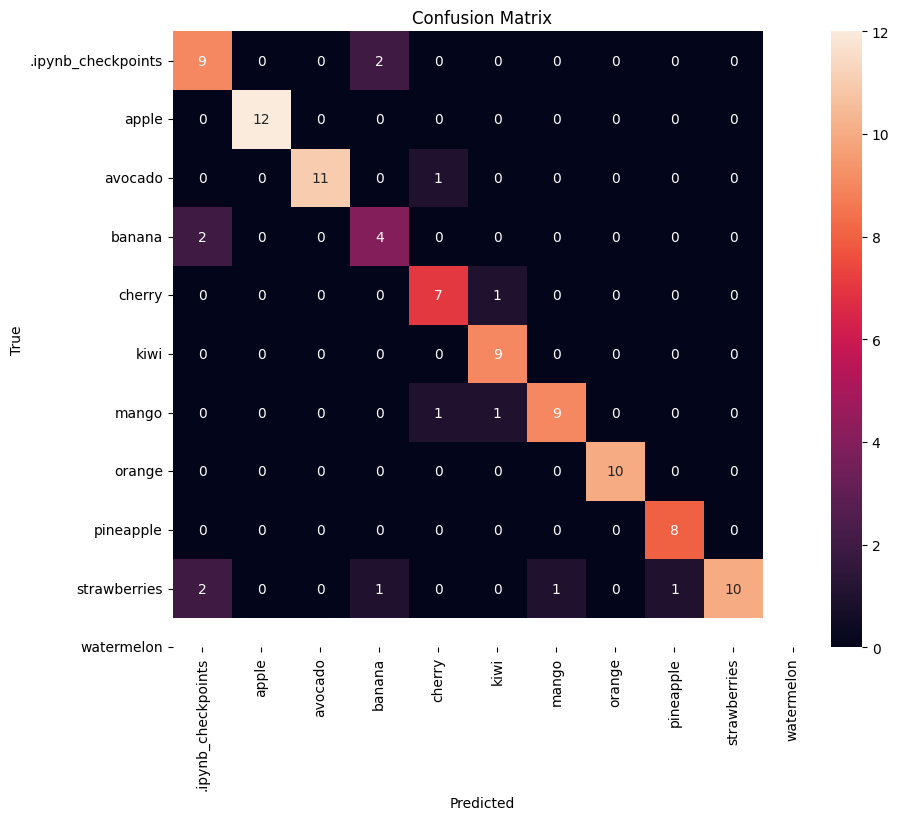

In [ ]:
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

cm = confusion_matrix(y_true, y_pred)

plt.figure(figsize=(10,8))
sns.heatmap(cm, annot=True, fmt='d',
            xticklabels=class_labels,
            yticklabels=class_labels)
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix")
plt.show()

## Error Analysis

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import cv2
import os

# Get predictions again (to be safe)
predictions = model.predict(test_generator)
y_pred = np.argmax(predictions, axis=1)
y_true = test_generator.classes

# Find incorrect indices
incorrect_indices = np.where(y_pred != y_true)[0]

print("Total wrong predictions:", len(incorrect_indices))

4/4 ━━━━━━━━━━━━━━━━━━━━ 8s 2s/step
Total wrong predictions: 13


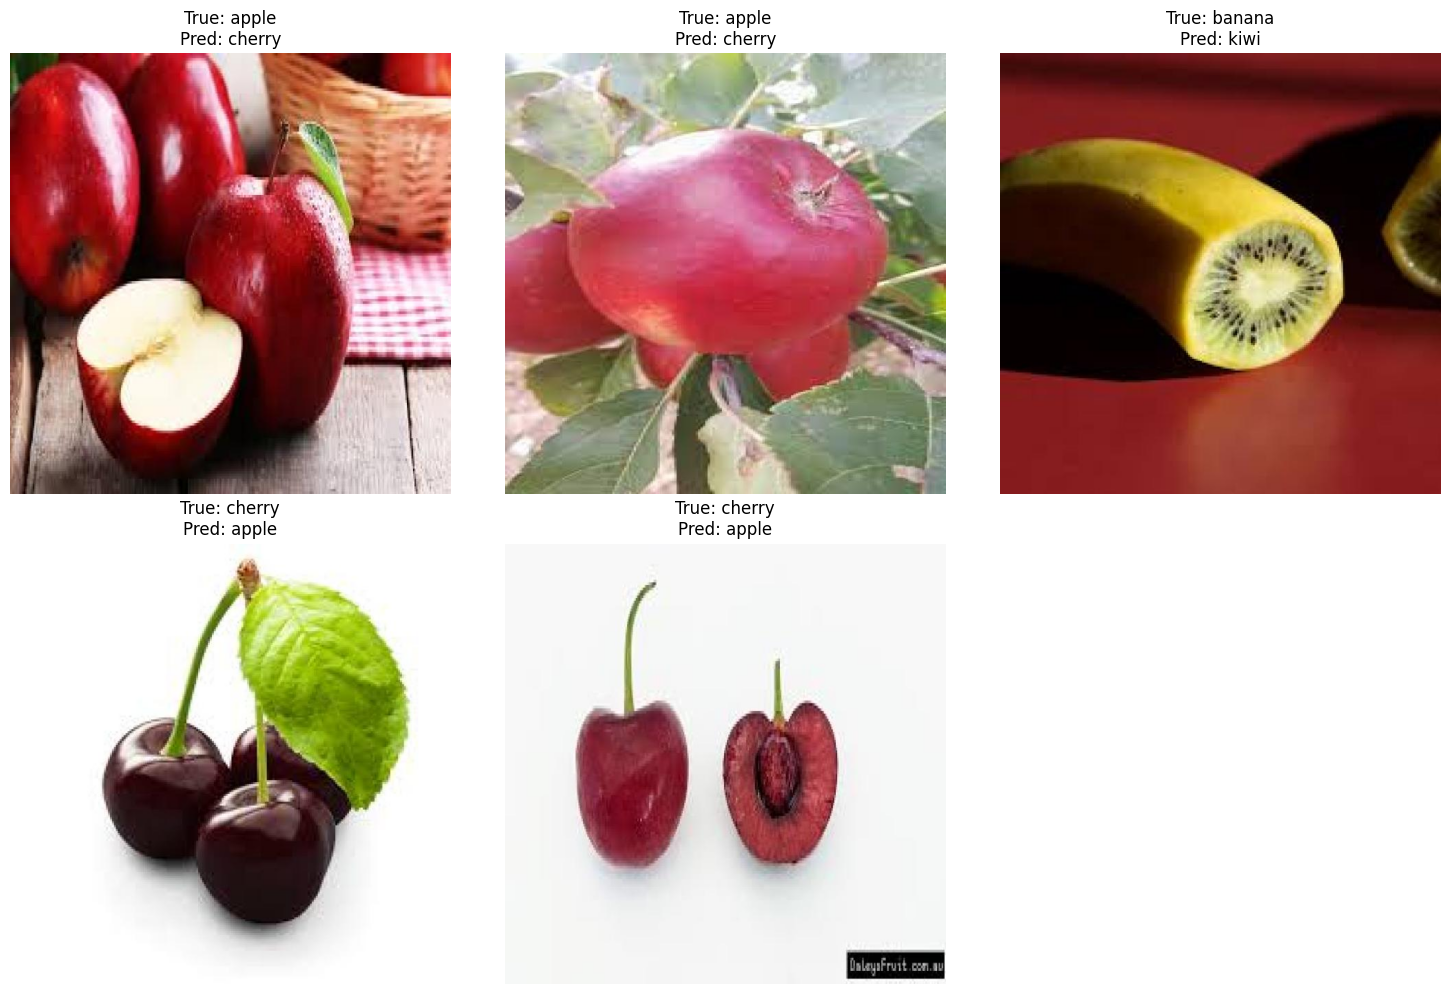

In [ ]:
class_labels = list(test_generator.class_indices.keys())

plt.figure(figsize=(15,10))

for i, idx in enumerate(incorrect_indices[:5]):
    img_path = test_generator.filepaths[idx]

    img = cv2.imread(img_path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

    true_label = class_labels[y_true[idx]]
    predicted_label = class_labels[y_pred[idx]]

    plt.subplot(2,3,i+1)
    plt.imshow(img)
    plt.title(f"True: {true_label}\nPred: {predicted_label}")
    plt.axis("off")

plt.tight_layout()
plt.show()

# Phase 5: Training Curves

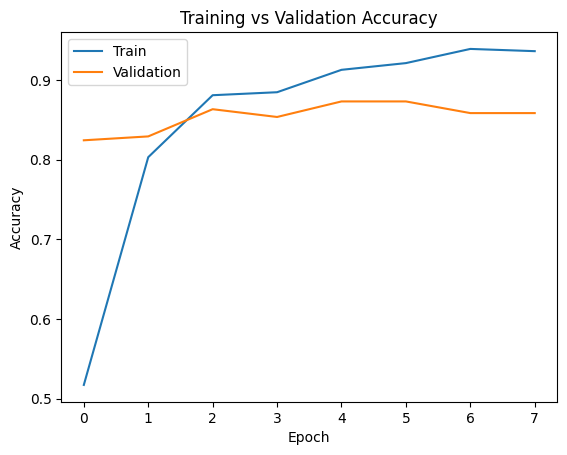

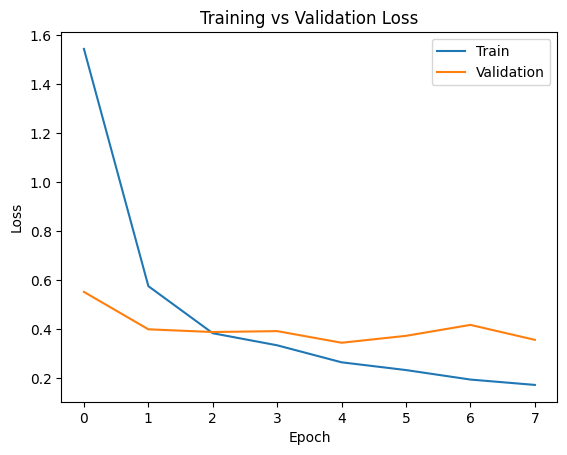

In [ ]:
plt.figure()
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title("Training vs Validation Accuracy")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.legend(["Train", "Validation"])
plt.show()

plt.figure()
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title("Training vs Validation Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend(["Train", "Validation"])
plt.show()

# Final Phase: Deployment Function

In [ ]:
import tensorflow as tf
import numpy as np
import cv2

def predict_fruit(image_path):
    img = cv2.imread(image_path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    img = cv2.resize(img, (224,224))

    img = np.expand_dims(img, axis=0)
    img = tf.keras.applications.mobilenet_v2.preprocess_input(img)

    prediction = model.predict(img)

    predicted_class = class_labels[np.argmax(prediction)]
    confidence = np.max(prediction)

    print(f"Predicted: {predicted_class}")
    print(f"Confidence: {confidence:.2f}")

    return predicted_class, confidence